### This notebook implements the MIAE method on the Washington DC Mall Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import torch.utils.data as data
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

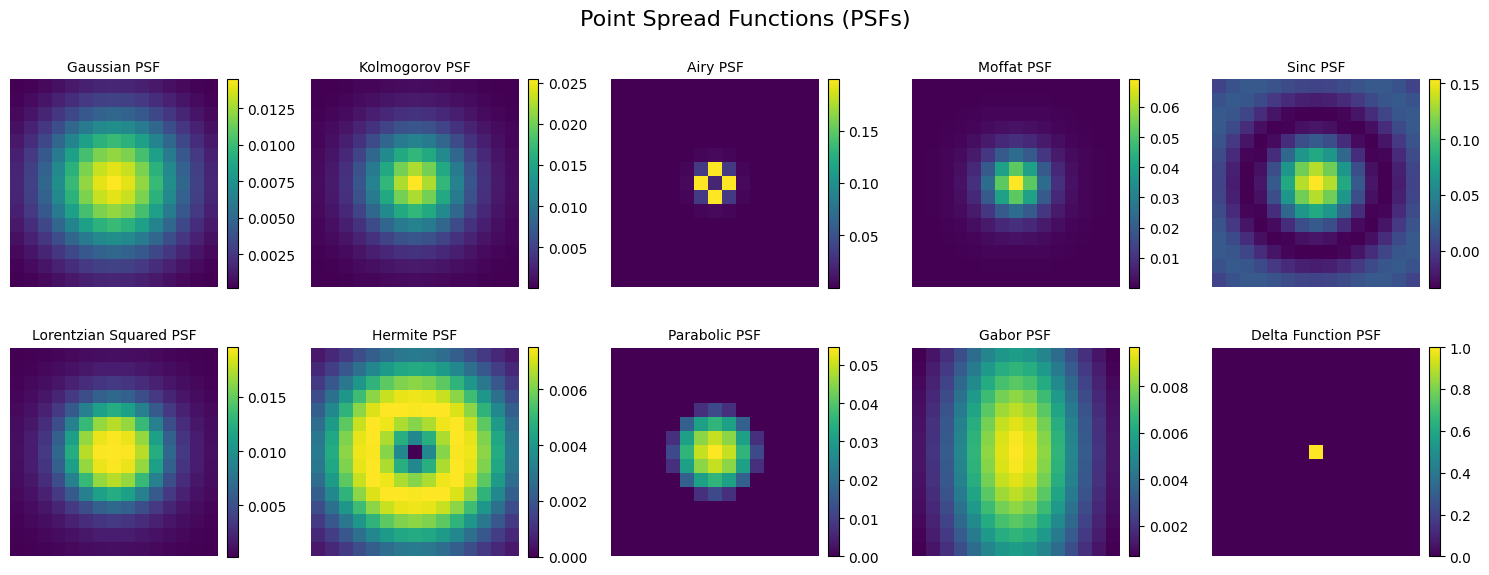

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img, bands, title):
    """
    Visualize a hyperspectral image by converting it to an RGB representation.
    
    Parameters:
    -----------
    img : np.ndarray
        Hyperspectral image array.
    bands : tuple
        Band indices to use for RGB representation.
    title : str
        Title for the plot.
    """
    img_rgb = get_rgb(img, bands)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Washington DC Mall HSI

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'DC_data.mat')

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth image shape:  (1280, 307, 191)


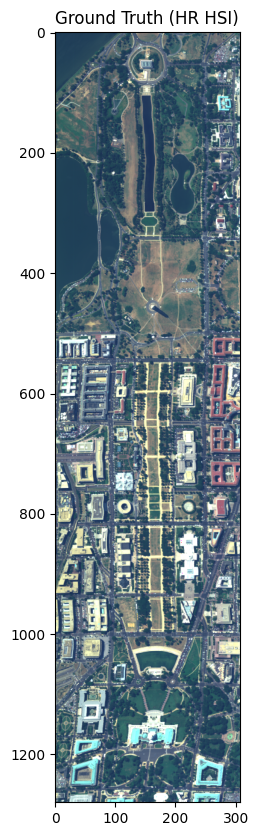

MSI shape:  (1280, 307, 1)


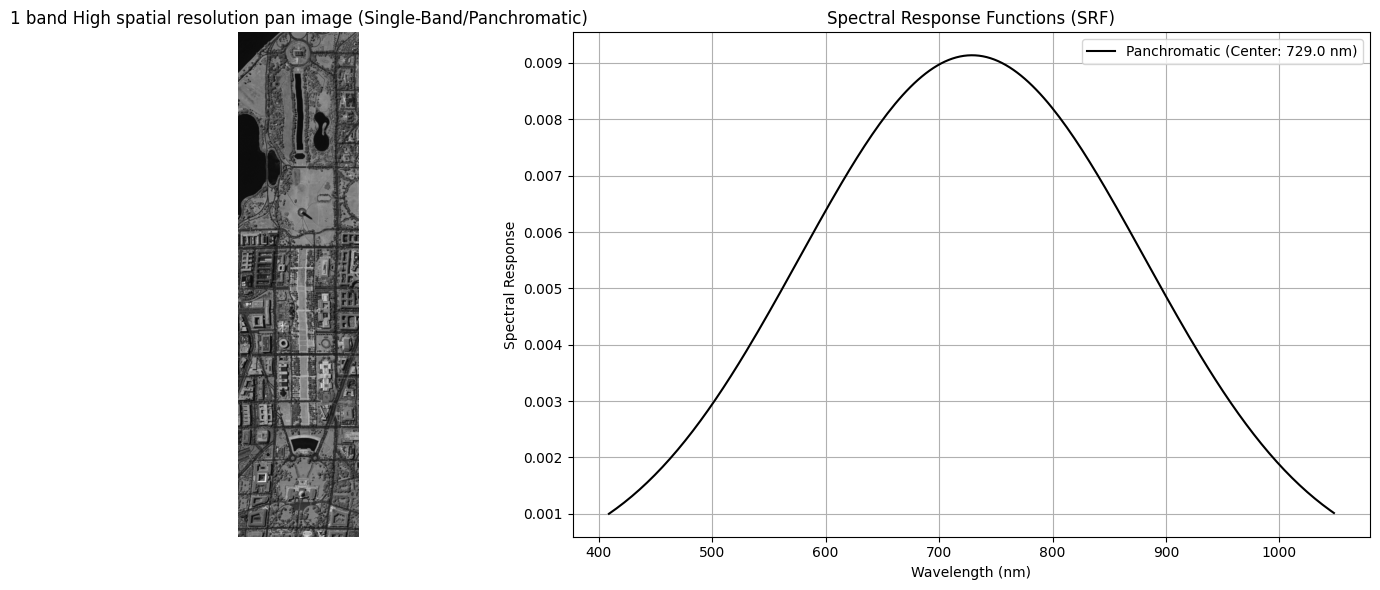

MSI shape:  (1280, 307, 3)


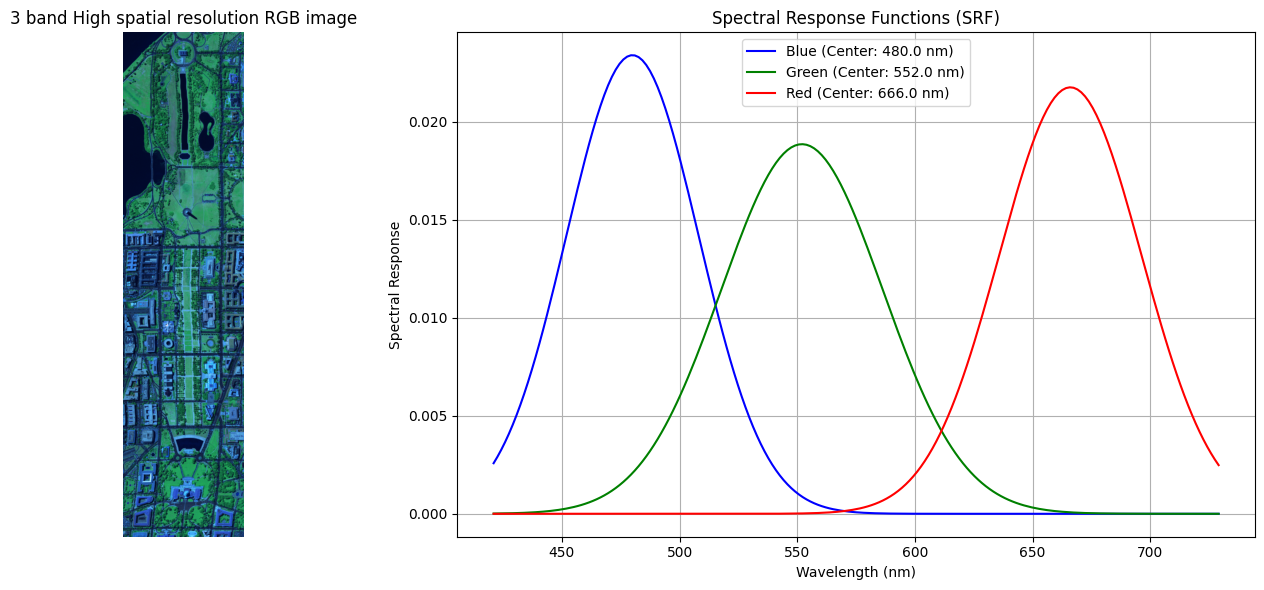

MSI shape:  (1280, 307, 4)


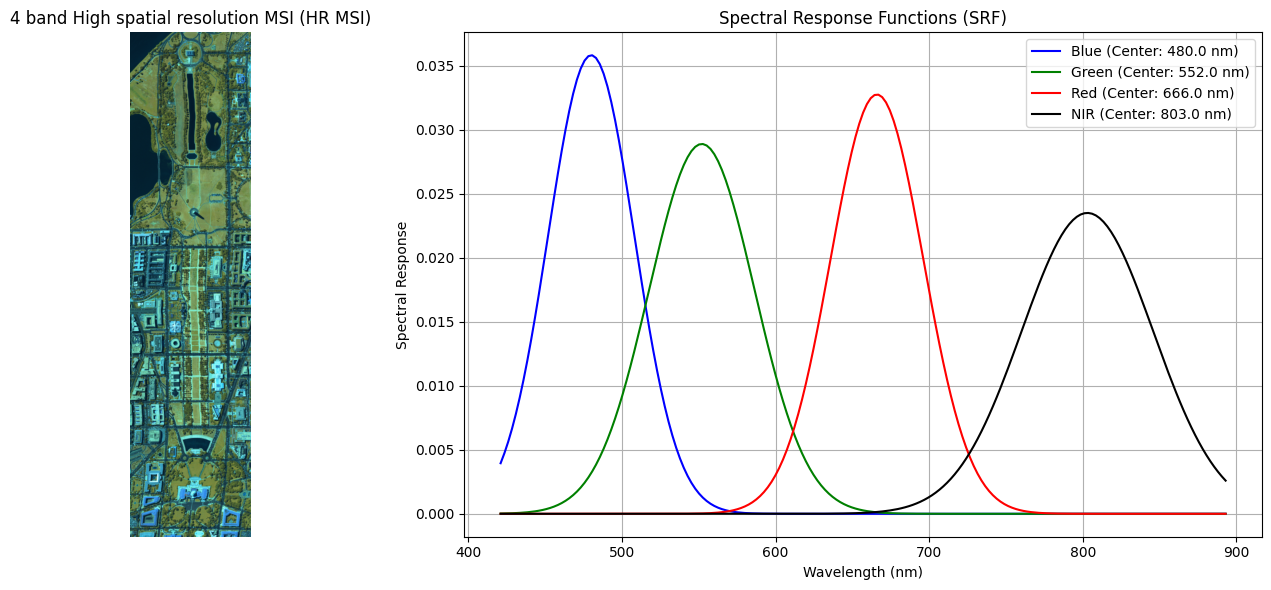

MSI shape:  (1280, 307, 8)


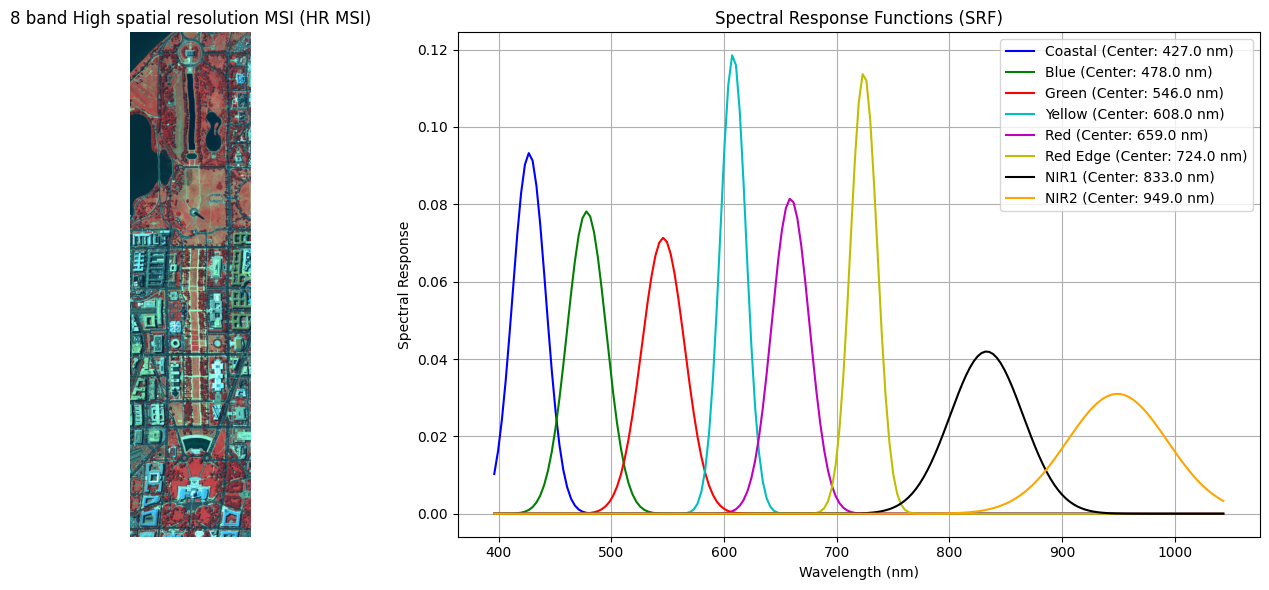

MSI shape:  (1280, 307, 16)


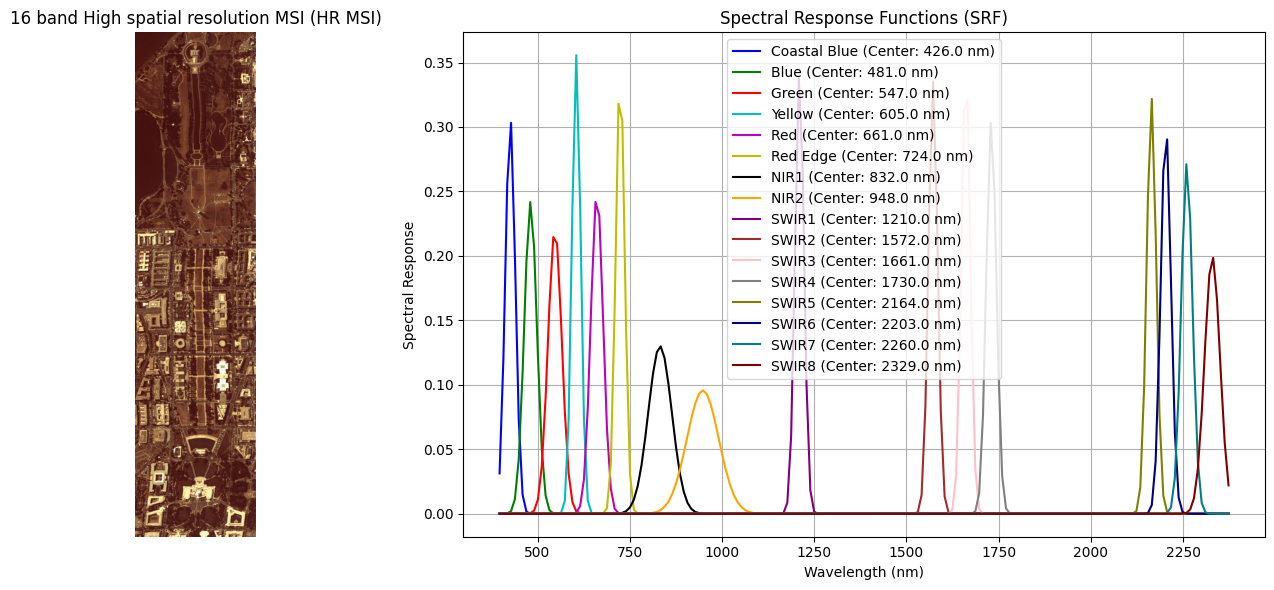

In [9]:
dc = sio.loadmat(mat_file_path)
dc_image = dc['dc']

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(dc_image)
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi(I_REF, (50,35,15), "Ground Truth (HR HSI)")

# High Resolution MSI with 1 band (H, W, 1)
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=dc_image, SNR=40, num_bands=1, fwhm_factor=4.2)
print("MSI shape: ", I_MS_1.shape)
plot_multispectral_with_srf(I_MS_1, None, "1 band High spatial resolution pan image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands (H, W, 3)
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=dc_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands (H, W, 4)
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=dc_image, SNR=40, num_bands=4, fwhm_factor=4.2)
print("MSI shape: ", I_MS_4.shape)
plot_multispectral_with_srf(I_MS_4, (2,1,0), "4 band High spatial resolution MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands (H, W, 8)
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=dc_image, SNR=40, num_bands=8, fwhm_factor=4.2)
print("MSI shape: ", I_MS_8.shape)
plot_multispectral_with_srf(I_MS_8, (4,2,1), "8 band High spatial resolution MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands (H, W, 16)
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=dc_image, SNR=40, num_bands=16, fwhm_factor=4.2)
print("MSI shape: ", I_MS_16.shape)
plot_multispectral_with_srf(I_MS_16, (4,2,1), "16 band High spatial resolution MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI shape with 4x Downsample:  (320, 76, 191)


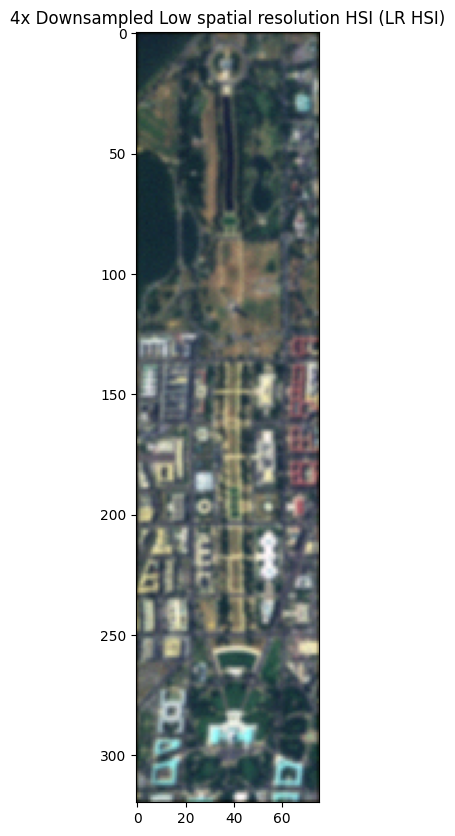

HSI shape with 8x Downsample:  (160, 38, 191)


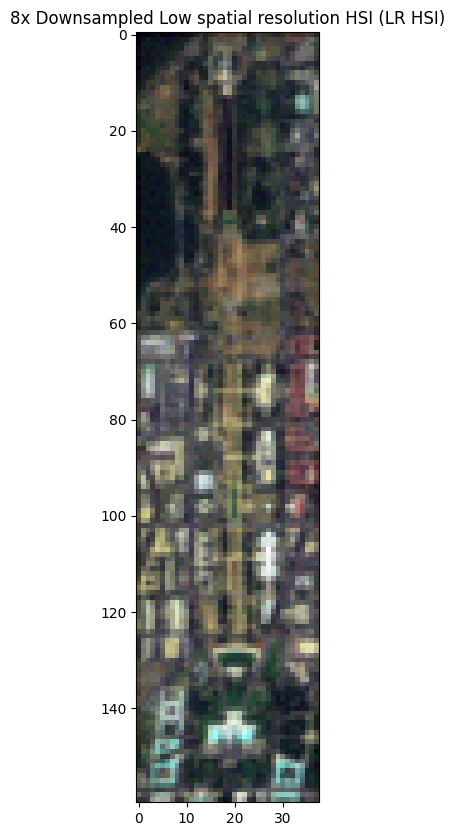

HSI shape with 16x Downsample:  (80, 19, 191)


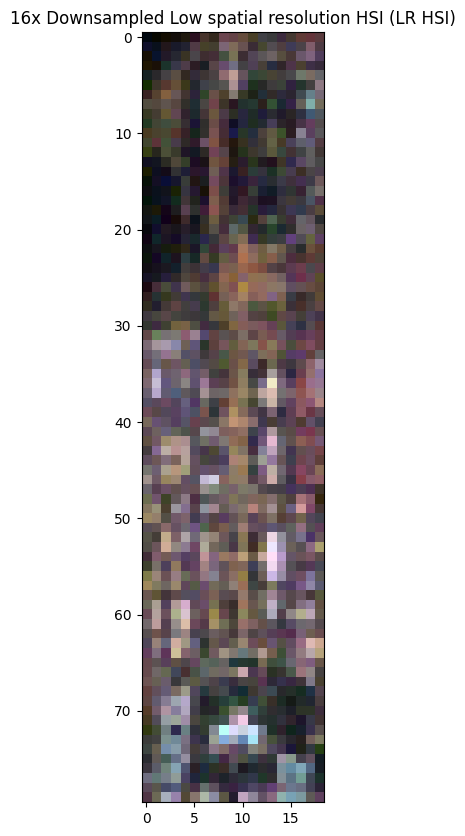

HSI shape with 32x Downsample:  (40, 9, 191)


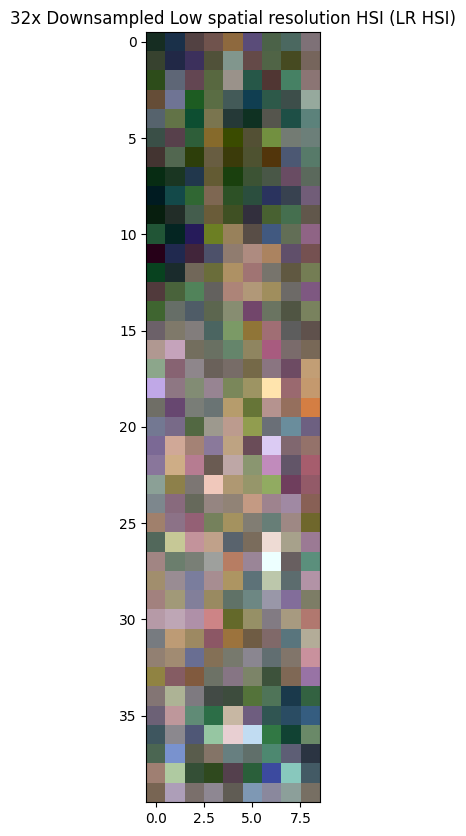

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(dc_image, gaus_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gaus.shape)
visualize_hsi(I_HS_4_gaus, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(dc_image, gaus_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi(I_HS_8_gaus, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(dc_image, gaus_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gaus.shape)
visualize_hsi(I_HS_16_gaus, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(dc_image, gaus_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gaus.shape)
visualize_hsi(I_HS_32_gaus, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI shape with 4x Downsample:  (320, 76, 191)


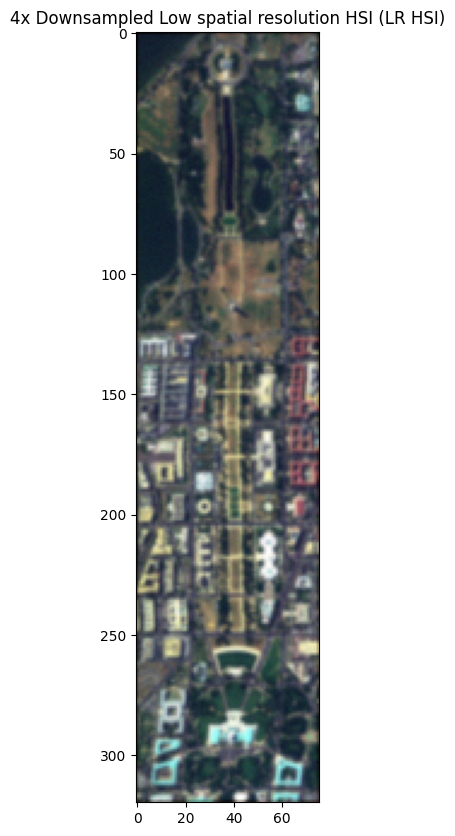

HSI shape with 8x Downsample:  (160, 38, 191)


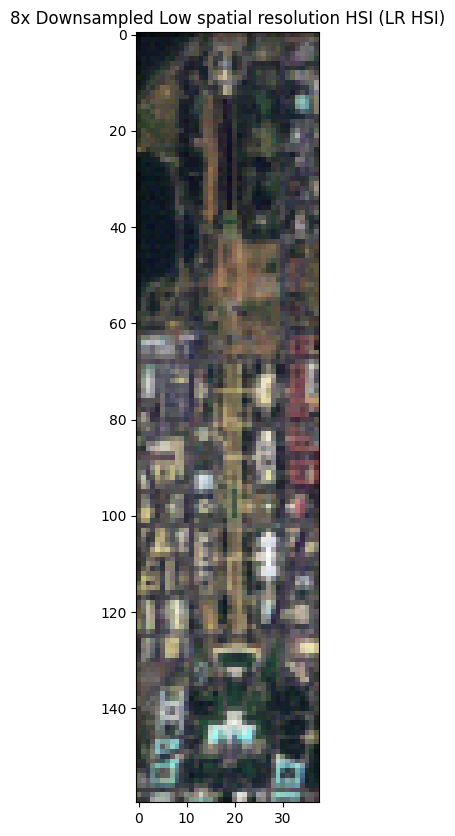

HSI shape with 16x Downsample:  (80, 19, 191)


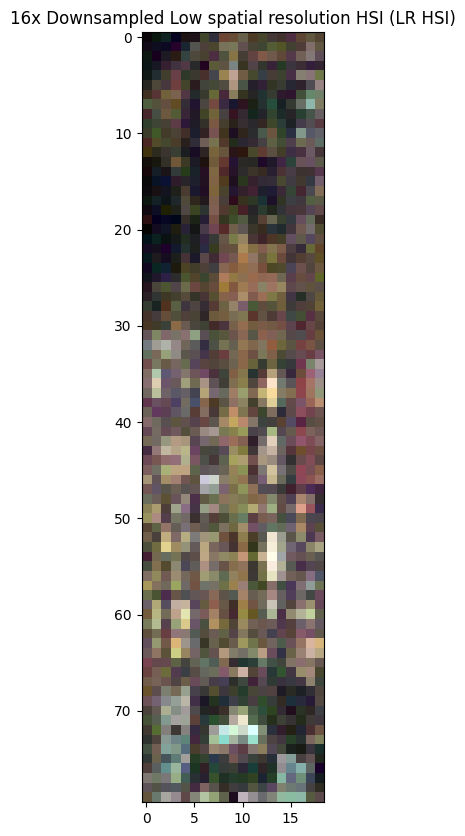

HSI shape with 32x Downsample:  (40, 9, 191)


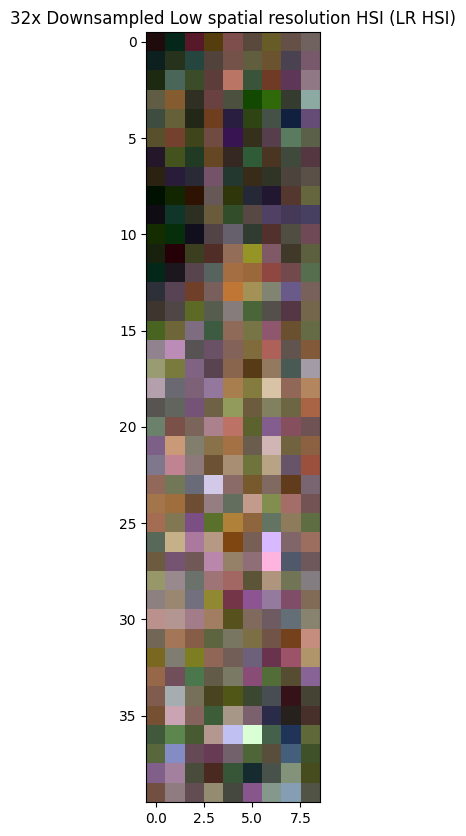

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(dc_image, kol_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_kol.shape)
visualize_hsi(I_HS_4_kol, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(dc_image, kol_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_kol.shape)
visualize_hsi(I_HS_8_kol, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(dc_image, kol_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_kol.shape)
visualize_hsi(I_HS_16_kol, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(dc_image, kol_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_kol.shape)
visualize_hsi(I_HS_32_kol, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Airy PSF

HSI shape with 4x Downsample:  (320, 76, 191)


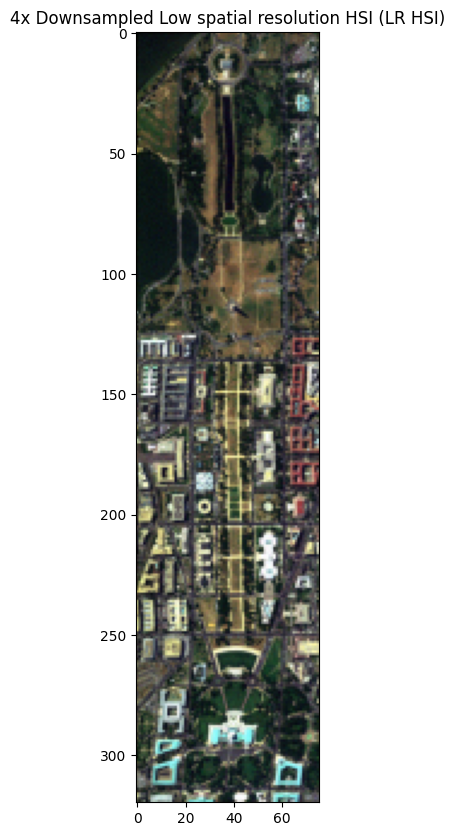

HSI shape with 8x Downsample:  (160, 38, 191)


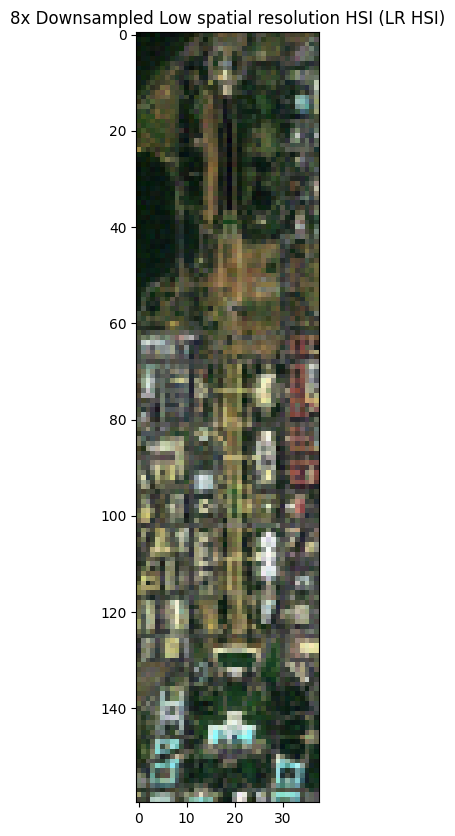

HSI shape with 16x Downsample:  (80, 19, 191)


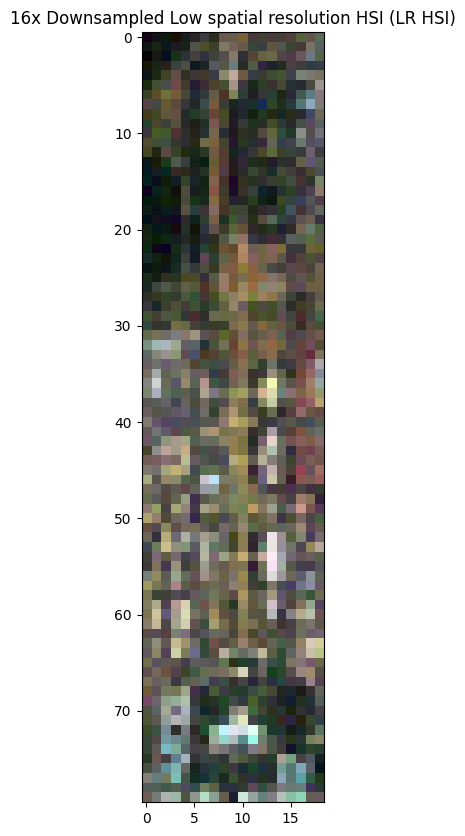

HSI shape with 32x Downsample:  (40, 9, 191)


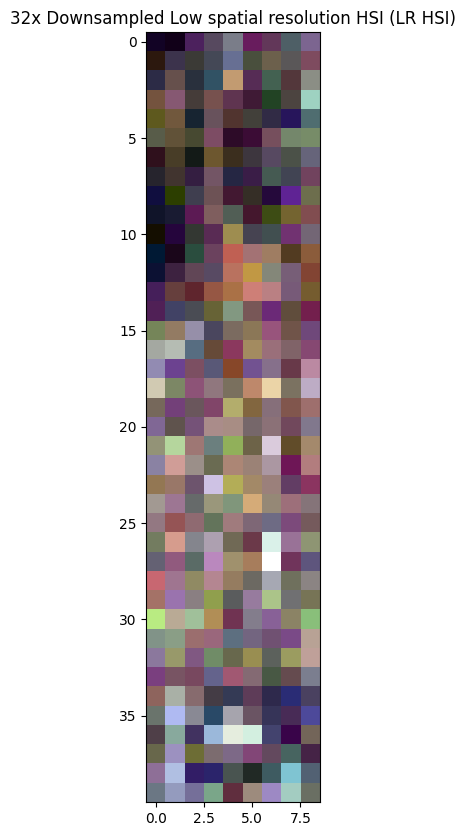

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(dc_image, air_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_air.shape)
visualize_hsi(I_HS_4_air, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(dc_image, air_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_air.shape)
visualize_hsi(I_HS_8_air, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(dc_image, air_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_air.shape)
visualize_hsi(I_HS_16_air, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(dc_image, air_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_air.shape)
visualize_hsi(I_HS_32_air, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Moffat PSF

HSI shape with 4x Downsample:  (320, 76, 191)


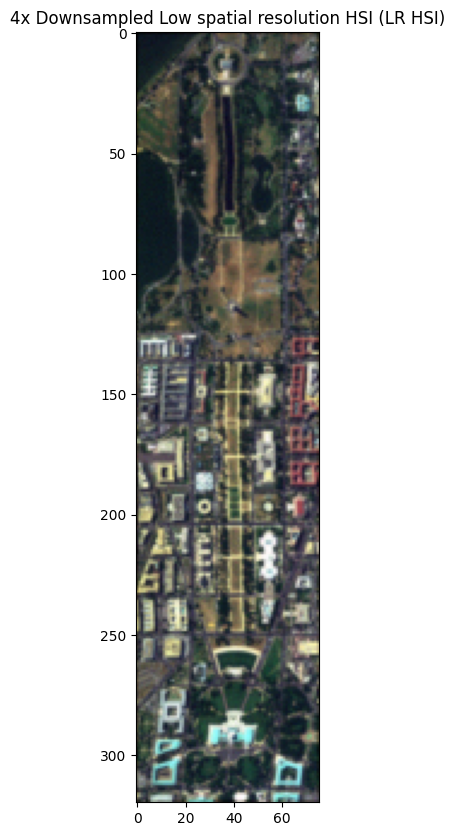

HSI shape with 8x Downsample:  (160, 38, 191)


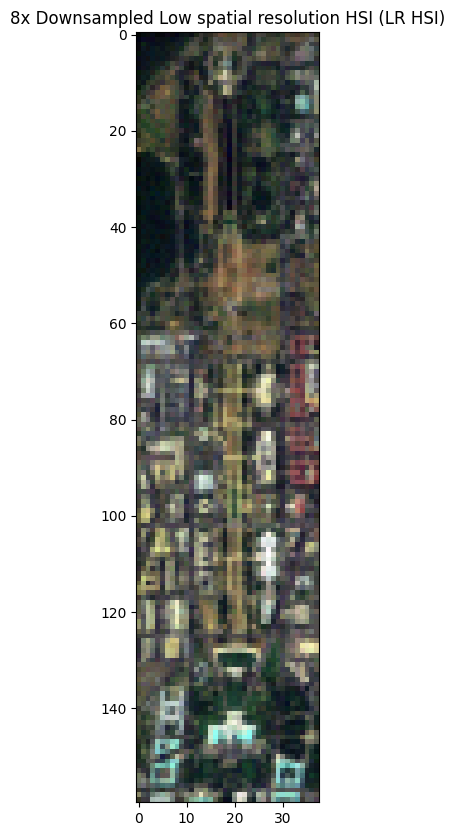

HSI shape with 16x Downsample:  (80, 19, 191)


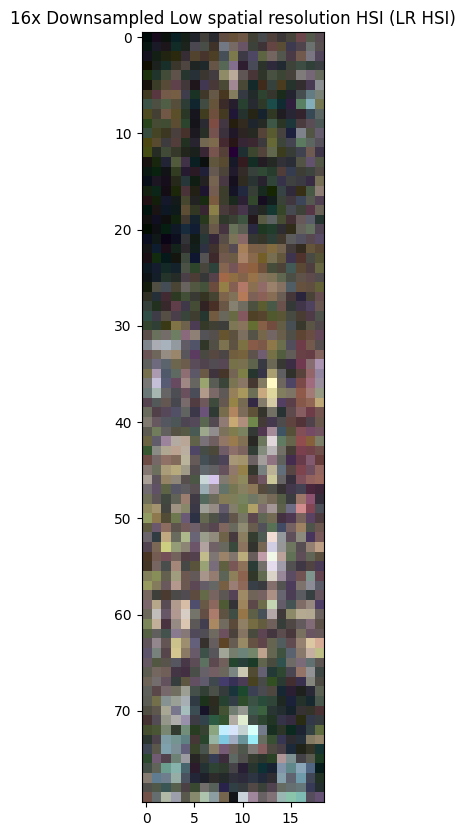

HSI shape with 32x Downsample:  (40, 9, 191)


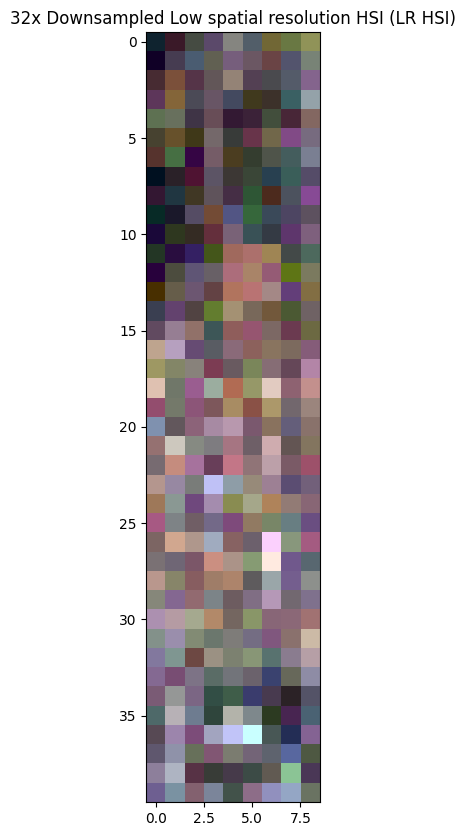

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(dc_image, mof_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_mof.shape)
visualize_hsi(I_HS_4_mof, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(dc_image, mof_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_mof.shape)
visualize_hsi(I_HS_8_mof, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(dc_image, mof_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_mof.shape)
visualize_hsi(I_HS_16_mof, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(dc_image, mof_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_mof.shape)
visualize_hsi(I_HS_32_mof, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Sinc PSF

HSI shape with 4x Downsample:  (320, 76, 191)


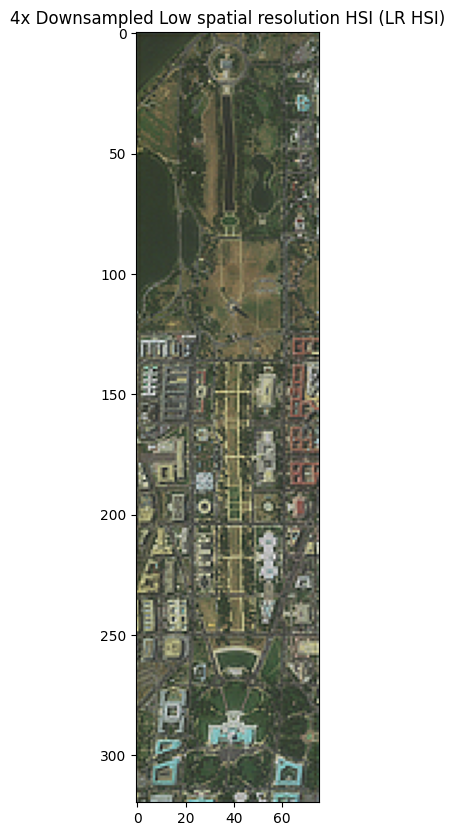

HSI shape with 8x Downsample:  (160, 38, 191)


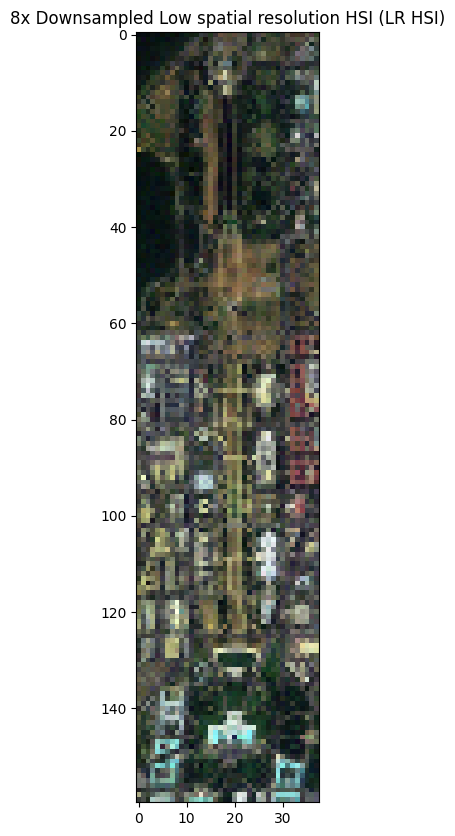

HSI shape with 16x Downsample:  (80, 19, 191)


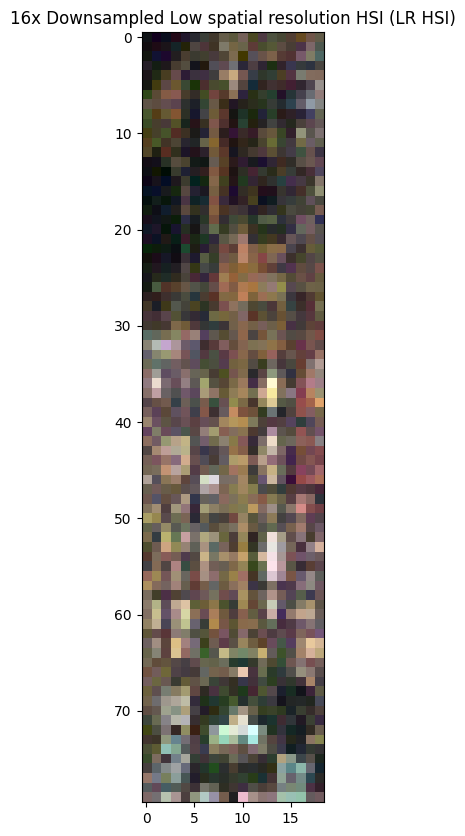

HSI shape with 32x Downsample:  (40, 9, 191)


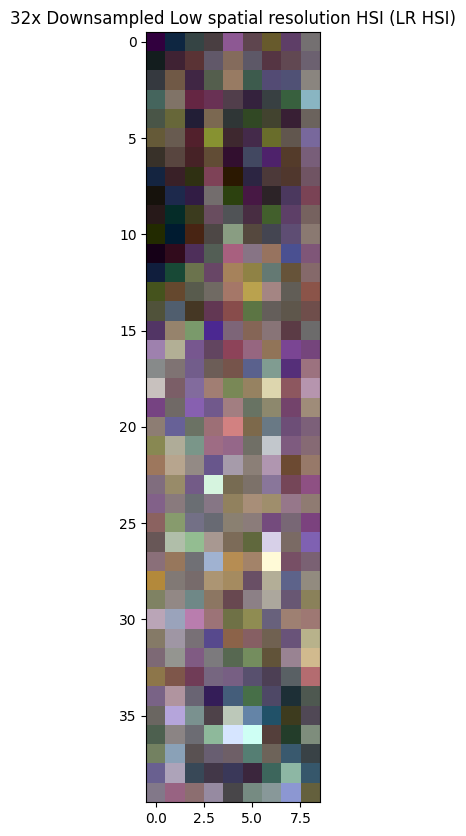

In [14]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(dc_image, sinc_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_sinc.shape)
visualize_hsi(I_HS_4_sinc, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(dc_image, sinc_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_sinc.shape)
visualize_hsi(I_HS_8_sinc, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(dc_image, sinc_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_sinc.shape)
visualize_hsi(I_HS_16_sinc, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(dc_image, sinc_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_sinc.shape)
visualize_hsi(I_HS_32_sinc, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI shape with 4x Downsample:  (320, 76, 191)


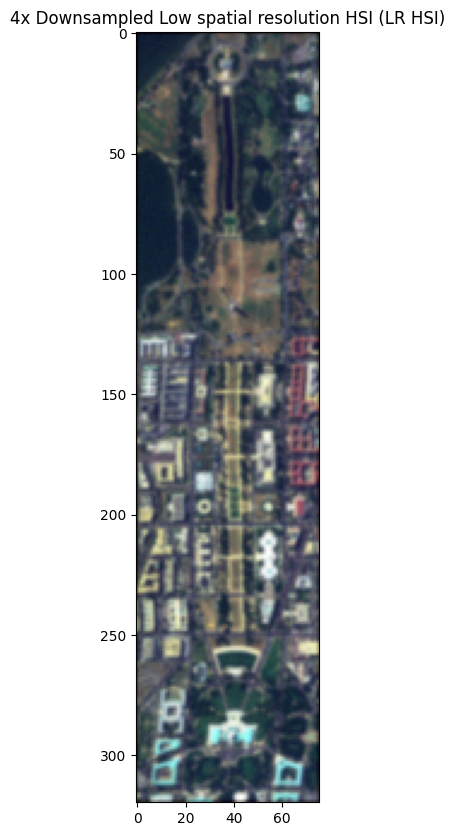

HSI shape with 8x Downsample:  (160, 38, 191)


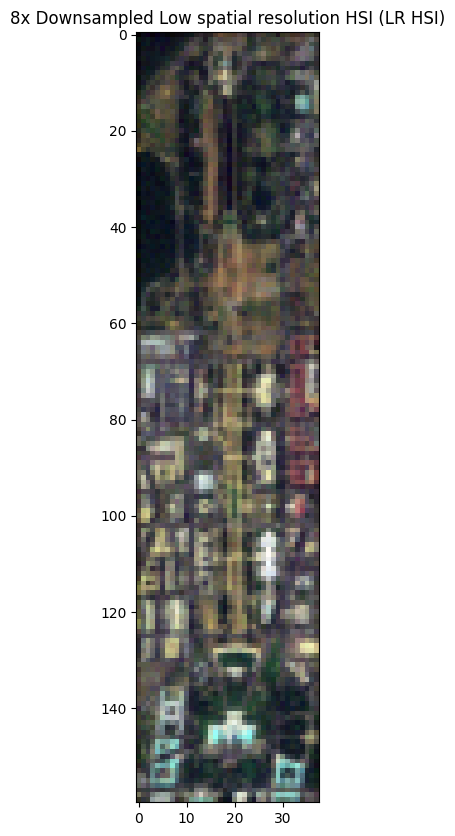

HSI shape with 16x Downsample:  (80, 19, 191)


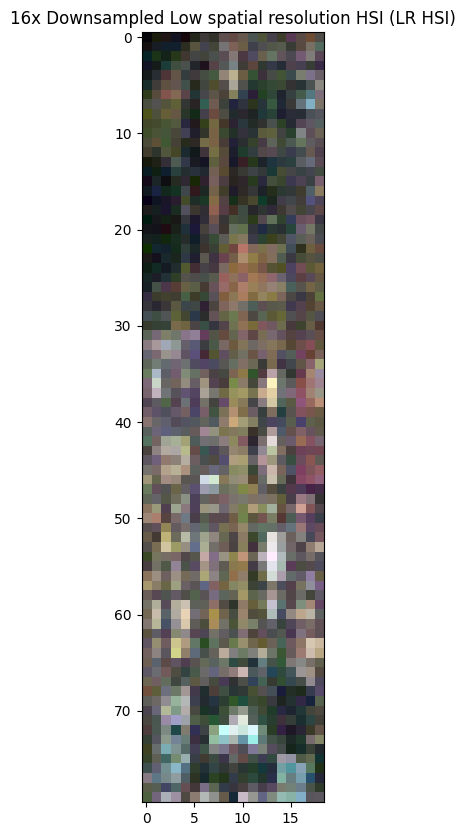

HSI shape with 32x Downsample:  (40, 9, 191)


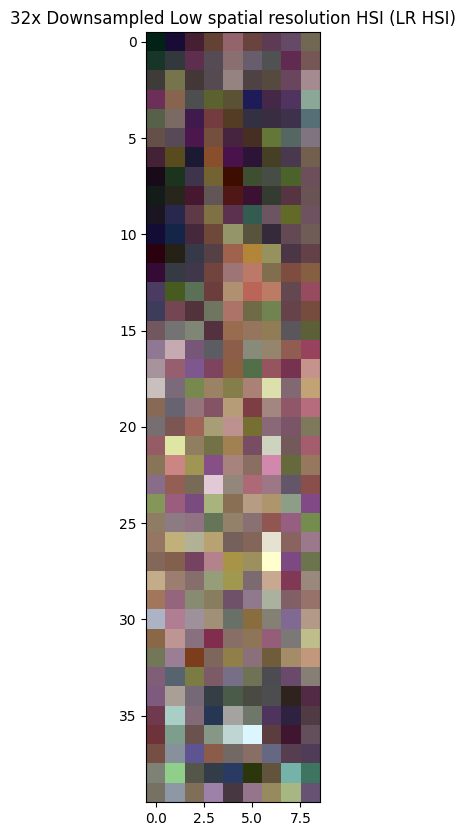

In [15]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(dc_image, lor_sq_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_lor_sq.shape)
visualize_hsi(I_HS_4_lor_sq, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(dc_image, lor_sq_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_lor_sq.shape)
visualize_hsi(I_HS_8_lor_sq, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(dc_image, lor_sq_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_lor_sq.shape)
visualize_hsi(I_HS_16_lor_sq, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(dc_image, lor_sq_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_lor_sq.shape)
visualize_hsi(I_HS_32_lor_sq, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Hermite PSF

HSI shape with 4x Downsample:  (320, 76, 191)


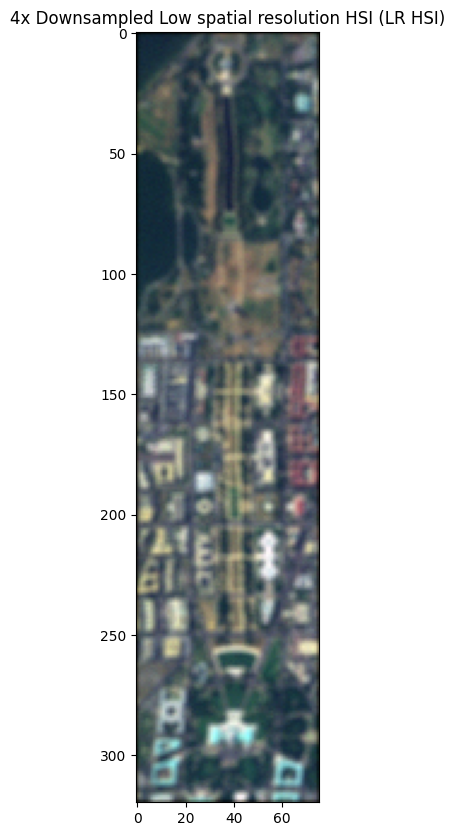

HSI shape with 8x Downsample:  (160, 38, 191)


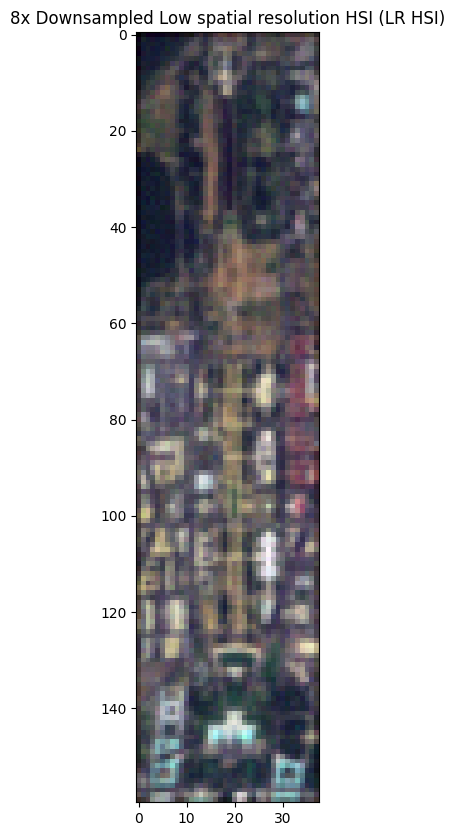

HSI shape with 16x Downsample:  (80, 19, 191)


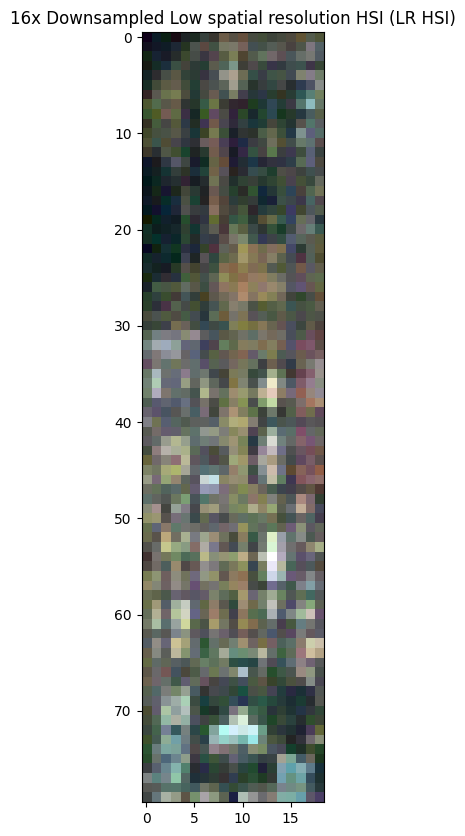

HSI shape with 32x Downsample:  (40, 9, 191)


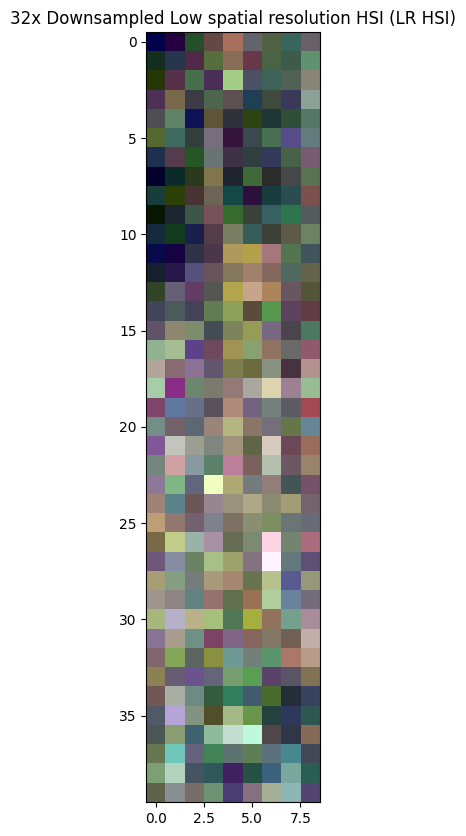

In [16]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(dc_image, her_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_her.shape)
visualize_hsi(I_HS_4_her, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(dc_image, her_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_her.shape)
visualize_hsi(I_HS_8_her, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(dc_image, her_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_her.shape)
visualize_hsi(I_HS_16_her, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(dc_image, her_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_her.shape)
visualize_hsi(I_HS_32_her, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Parabolic PSF

HSI shape with 4x Downsample:  (320, 76, 191)


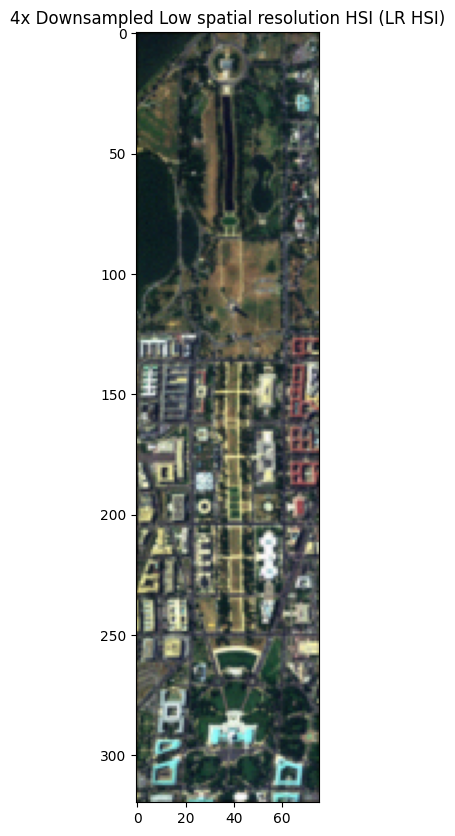

HSI shape with 8x Downsample:  (160, 38, 191)


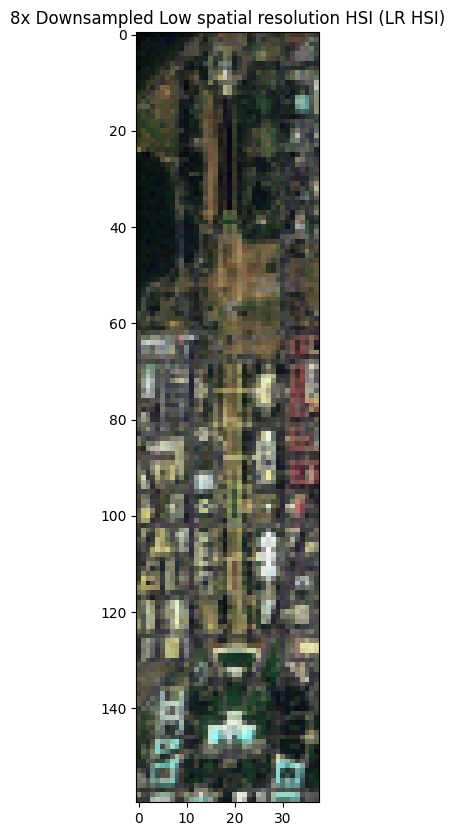

HSI shape with 16x Downsample:  (80, 19, 191)


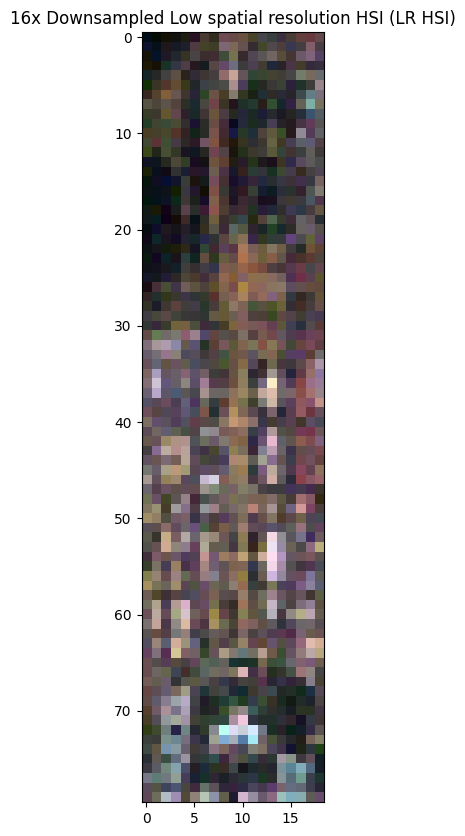

HSI shape with 32x Downsample:  (40, 9, 191)


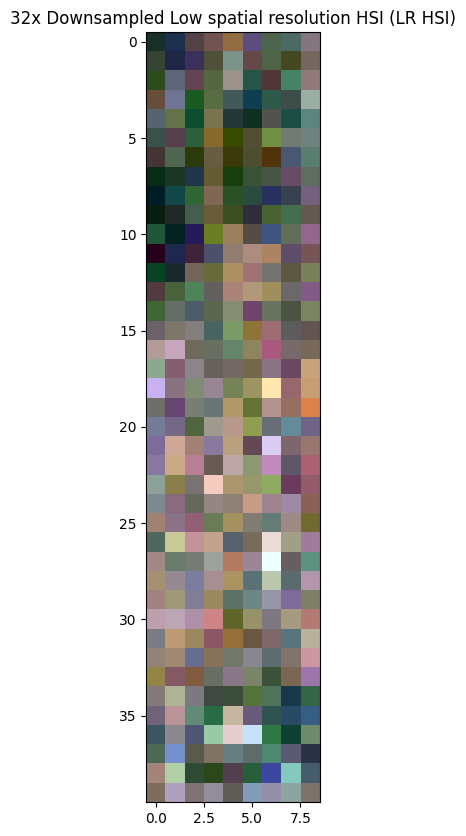

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(dc_image, par_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_par.shape)
visualize_hsi(I_HS_4_par, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(dc_image, par_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_par.shape)
visualize_hsi(I_HS_8_par, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(dc_image, par_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_par.shape)
visualize_hsi(I_HS_16_par, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(dc_image, par_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_par.shape)
visualize_hsi(I_HS_32_par, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Gabor PSF

HSI shape with 4x Downsample:  (320, 76, 191)


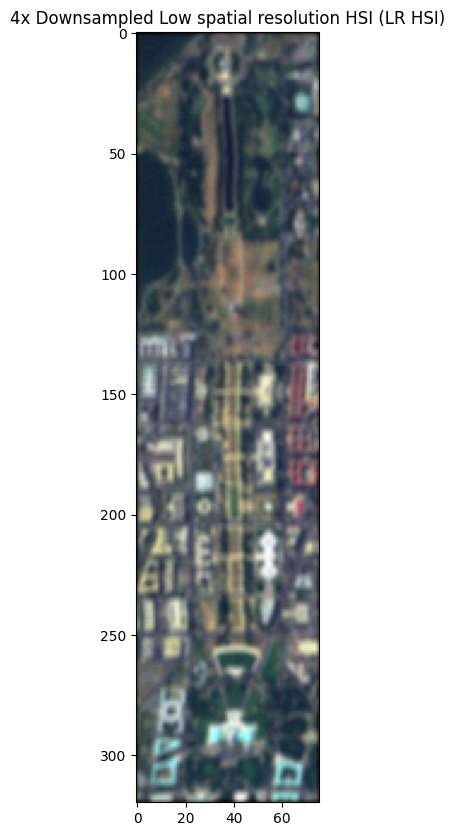

HSI shape with 8x Downsample:  (160, 38, 191)


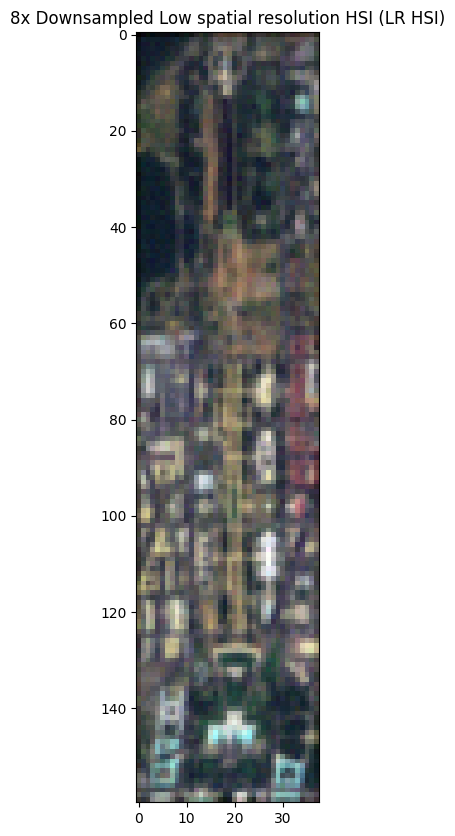

HSI shape with 16x Downsample:  (80, 19, 191)


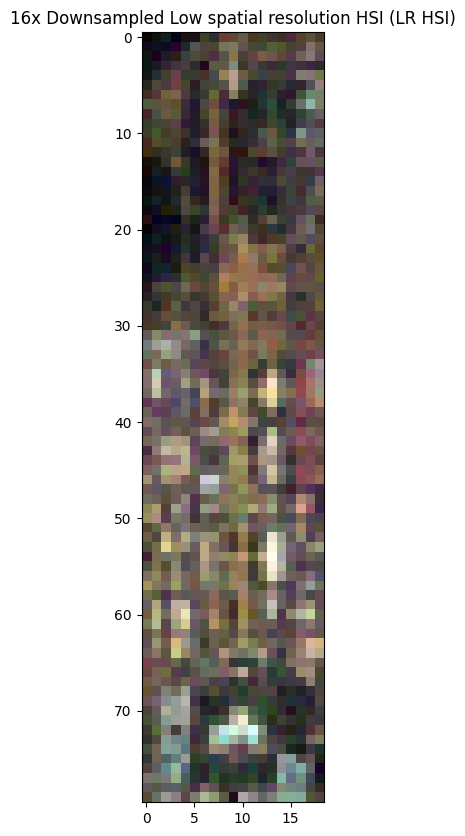

HSI shape with 32x Downsample:  (40, 9, 191)


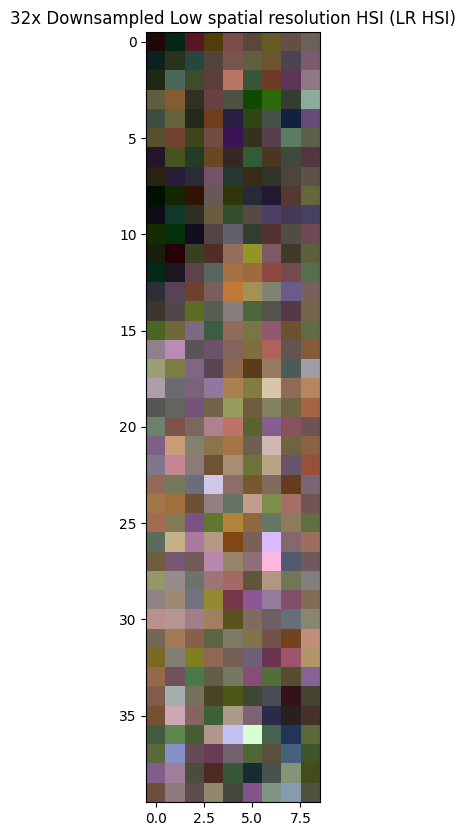

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(dc_image, gab_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gab.shape)
visualize_hsi(I_HS_4_gab, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(dc_image, gab_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gab.shape)
visualize_hsi(I_HS_8_gab, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(dc_image, gab_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gab.shape)
visualize_hsi(I_HS_16_gab, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(dc_image, gab_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gab.shape)
visualize_hsi(I_HS_32_gab, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Delta PSF

HSI shape with 4x Downsample:  (320, 76, 191)


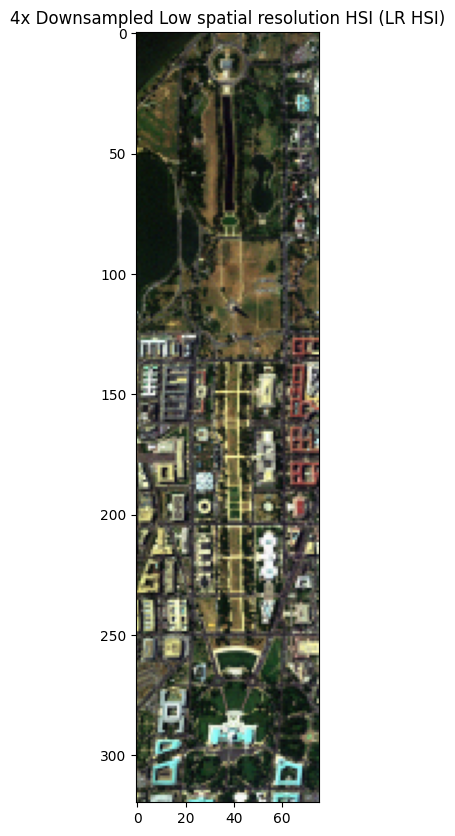

HSI shape with 8x Downsample:  (160, 38, 191)


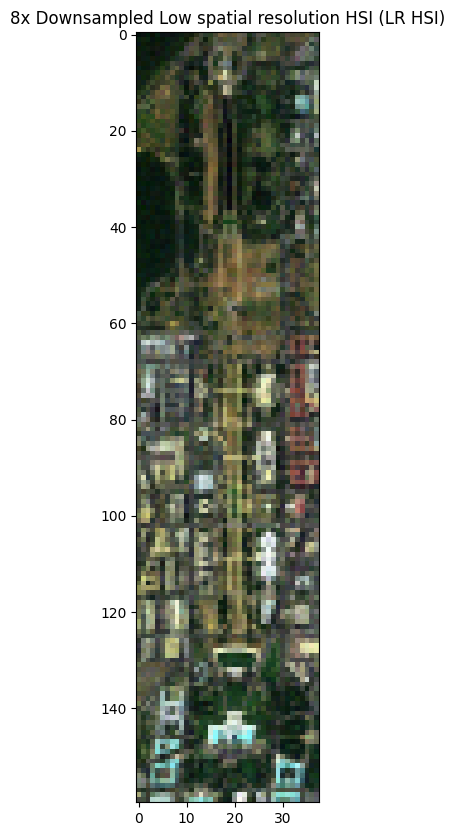

HSI shape with 16x Downsample:  (80, 19, 191)


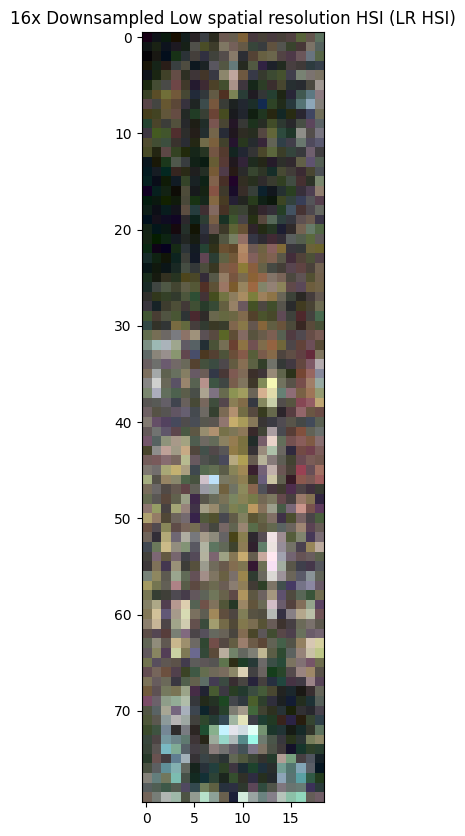

HSI shape with 32x Downsample:  (40, 9, 191)


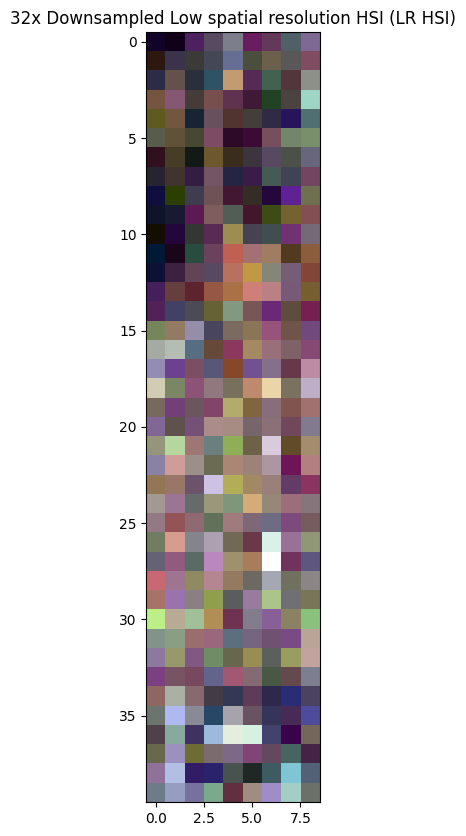

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(dc_image, delta_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_delta.shape)
visualize_hsi(I_HS_4_delta, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(dc_image, delta_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_delta.shape)
visualize_hsi(I_HS_8_delta, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(dc_image, delta_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_delta.shape)
visualize_hsi(I_HS_16_delta, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(dc_image, delta_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_delta.shape)
visualize_hsi(I_HS_32_delta, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

MIAE: Model Inspired Autoencoder for Unsupervised Hyperspectral Image Super-Resolution implementation from their GitHub

In [13]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [14]:
class BlurDown:
    def __init__(self, out_h, out_w, pad_mode='constant'):
        self.out_h = out_h
        self.out_w = out_w
        self.pad_mode = pad_mode  # 'constant', 'reflect', etc.

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups):
        """
        input_tensor: (N, C, H, W)
        psf:          (C, 1, kH, kW) or (1,1,kH,kW)
        pad:          integer for conv2d padding
        groups:       typically = C (each channel blurred individually)
        out_h, out_w: final desired spatial size
        """
        # 1) Repeat psf across channels if needed
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)

        # 2) Convolve with stride=1 => just blur
        blurred = fun.conv2d(input_tensor, psf, stride=1, padding=(pad, pad), groups=groups)

        # 3) Resize to (out_h, out_w). 
        out = fun.interpolate(blurred, size=(self.out_h, self.out_w), mode='bilinear')

        return out

In [15]:
class AENet(nn.Module):
    def __init__(self, hs_bands, ms_bands, edm_num, stage=3):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.edm_num = edm_num
        self.stage = stage
        self.module_list = nn.ModuleList([])
        edm = torch.ones([self.hs_bands, self.edm_num, 1, 1]) * (1.0 / self.edm_num)
        self.edm = nn.Parameter(edm)
        self.Y_net = nn.Sequential(
            nn.Conv2d(self.hs_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.Z_net = nn.Sequential(
            nn.Conv2d(self.ms_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.S0_net = nn.Sequential(
            nn.Conv2d(2 * self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        for k in range(0, self.stage - 1):
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(3 * self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
        self._init_weights(self)
        pass

    def forward(self, Yu, Z):
        N, B, H, W = Yu.shape
        N, b, H, W = Z.shape
        Y1 = self.Y_net(Yu)
        Z1 = self.Z_net(Z)
        S = torch.cat([Y1, Z1], dim=1)
        S = self.S0_net(S)
        for k in range(0, self.stage - 1):
            S = self.module_list[2 * k - 2](S)
            S = torch.cat([S, Y1, Z1], dim=1)
            S = self.module_list[2 * k - 1](S)
        S = torch.clamp(S, 0.0, 1.0)
        X = fun.conv2d(S, self.edm, None)
        X = torch.clamp(X, 0.0, 1.0)
        return X

    @staticmethod
    def _init_weights(model, init_type='normal'):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                num_inputs = m.weight.data.shape[1]
                if init_type == 'normal':
                    nn.init.trunc_normal_(m.weight.data, mean=0.0, std=np.sqrt(1.0 / num_inputs))
                elif init_type == 'constant':
                    nn.init.constant_(m.weight.data, 1.0 / num_inputs)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
        pass

In [16]:
class MIAE:
    def __init__(
        self,
        I_HS: np.ndarray,    # shape (h, w, L)
        I_MS: np.ndarray,    # shape (H, W, l)
        I_REF: np.ndarray,   # shape (H, W, L) or None
        psf: np.ndarray,     # shape (K, K)
        srf: np.ndarray,     # shape (l, L)
        ratio=8, 
        edm_num=80,
        stage=3
    ):
        """
        I_HS: low-res HSI
        I_MS: MSI
        I_REF: optional ground-truth for metrics
        psf:  PSF (K,K)
        srf:  SRF (l,L)
        ratio: upsampling factor
        edm_num, stage: architecture for AENet
        """

        # Convert input arrays to float32
        I_HS = I_HS.astype(np.float32)
        I_MS = I_MS.astype(np.float32)
        self.ref = I_REF.astype(np.float32) if I_REF is not None else None

        # Basic shapes
        self.h, self.w, self.hs_bands = I_HS.shape
        self.H, self.W, self.ms_bands = I_MS.shape
        self.ratio = ratio

        # Convert to Torch (channel-first)
        # => shape (1, L, h, w)
        self.hsi = torch.from_numpy(np.transpose(I_HS, (2,0,1))[None, ...])
        # => shape (1, l, H, W)
        self.msi = torch.from_numpy(np.transpose(I_MS, (2,0,1))[None, ...])

        # Upsample the HSI by ratio (bilinear), matching original code
        self.__hsi_up = nn.Upsample(size=(self.H, self.W), mode='bilinear', align_corners=False)(self.hsi)

        # Prepare PSF => (1,1,K,K), then replicate across L channels
        self.ker_size = psf.shape[0]
        self.psf = torch.tensor(psf[np.newaxis, np.newaxis, ...].astype(np.float32))
        self.psf_hs = self.psf.repeat(self.hs_bands, 1, 1, 1)  # => (L,1,K,K)

        # Prepare SRF => (l, L, 1,1)
        srf_4d = srf.astype(np.float32)[:, :, np.newaxis, np.newaxis]
        self.srf = torch.tensor(srf_4d)

        # Same hyperparams as original
        self.lr = 0.005
        self.lam_A, self.lam_B, self.lam_C = 1, 1, 1e-3

        # Build AENet
        self.model = AENet(self.hs_bands, self.ms_bands, edm_num, stage)

        # Move all to device
        self.__hsi    = self.hsi.float().to(device)
        self.__msi    = self.msi.float().to(device)
        self.__hsi_up = self.__hsi_up.float().to(device)
        self.psf_hs   = self.psf_hs.to(device)
        self.srf      = self.srf.to(device)
        self.model    = self.model.to(device)

        # Adam optimizer with weight decay = lam_C
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.lam_C)
        # Original code uses a LambdaLR:
        self.lr_fun = lambda epoch: (1.0 - max(0, epoch + 1 - 1000) / 9000)
        self.scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, self.lr_fun)

        # Patch training parameters
        self.patch_size   = 5 * self.ratio
        self.patch_stride = 3 * self.ratio
        self.batch_size   = self.set_batch_size()

        # Border cut
        self.hs_border = math.ceil((self.ker_size - 1) / 2 / self.ratio)
        self.ms_border = self.hs_border * self.ratio

        # The blur-down object for cpt_target
        self.blur_down = BlurDown(out_h=self.h, out_w=self.w)

    def set_batch_size(self):
        """
        Same logic as the original set_batch_size function:
        if ratio==8 => base=25, etc., and multiply by (H//512)*(W//256).
        """
        batch_size = 100
        if self.ratio == 4:
            batch_size = 100
        elif self.ratio == 8:
            batch_size = 25
        elif self.ratio == 16:
            batch_size = 5
        factor = (self.H // 512) * (self.W // 256)
        factor = max(factor, 1)  # ensure not zero
        return batch_size * factor

    def cpt_target(self, X):
        """
        Spatial degrade: blur + downsample => Y
        Spectral degrade: conv with srf => Z
        Compare (Y,Z) to (lrHSI, MSI) in build_loss
        """
        # => Y
        pad = int((self.ker_size - 1) / 2)
        Y = self.blur_down(
            input_tensor=X,
            psf=self.psf_hs,
            pad=int((self.ker_size-1)//2),
            groups=self.hs_bands
        )
                # => Z
        Z = fun.conv2d(X, self.srf, None)
        return Y, Z

    def build_loss(self, Y, Z, hsi, msi):
        """
        L1 difference, ignoring border. Weighted by lam_A, lam_B.
        """
        
        dY = Y - hsi
        dZ = Z - msi
        dY = dY[:, :, self.hs_border:-self.hs_border, self.hs_border:-self.hs_border]
        dZ = dZ[:, :, self.ms_border:-self.ms_border, self.ms_border:-self.ms_border]

        loss_spatial = torch.sum(torch.mean(torch.abs(dY), dim=(2,3))) * ((self.H/self.ratio)*(self.W/self.ratio))
        loss_spectral = torch.sum(torch.mean(torch.abs(dZ), dim=(2,3))) * (self.H*self.W)
        return self.lam_A*loss_spatial + self.lam_B*loss_spectral

    def train_all(self, max_iter=10000, verb=True):
        """
        Alternative training with the entire image each iteration (no patches).
        Use a tqdm progress bar to track progress.
        """
        t_start = time.perf_counter()
        hsi = self.__hsi.to(device)
        msi = self.__msi.to(device)
        hsi_up = self.__hsi_up.to(device)
        self.model.train()

        # Create a tqdm bar that goes from 0 to max_iter
        pbar = tqdm(range(max_iter), desc="Training (no patches)", ncols=80)
        for epoch in pbar:
            X = self.model(hsi_up, msi)
            Yhat, Zhat = self.cpt_target(X)
            loss = self.build_loss(Yhat, Zhat, hsi, msi)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.model.edm.data.clamp_(0.0, 1.0)

            # Update the progress bar's postfix to show current loss
            pbar.set_postfix(loss=f"{loss.item():.4f}")

            self.scheduler.step()

        pbar.close()  # close the progress bar
        train_time = time.perf_counter() - t_start
        print(f"Train_all done in {train_time:.2f}s")
        
    def get_super_resolved(self):
        """
        Obtain the final super-resolved HSI (H,W,L) as a NumPy array.
        Also calculate FLOPs, number of parameters, GPU memory consumed, and inference time.
        """
        self.model.eval()
        
        # Determine the device (GPU if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Number of parameters
        num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        # FLOPs using fvcore
        inputs = (self.__hsi_up.to(device), self.__msi.to(device))
        flops, param_table = get_flops_fvcore(self.model, inputs)
        
        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)
        
        with torch.no_grad():
            # Measure inference time
            start_time = time.time()
            X = self.model(self.__hsi_up.to(device), self.__msi.to(device))
            end_time = time.time()
            
        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory
        
        # Shape (1, L, H, W) => (L, H, W) => (H, W, L)
        X_np = X[0].cpu().numpy()
        X_np = np.transpose(X_np, (1, 2, 0))
        
        # Print metrics
        print(f"Number of parameters: {num_params}")
        print(f"FLOPs: {flops}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")
        
        return X_np

Output file to save super-resolved images

In [17]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/MIAE"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the MIAE folder
dc_miae_folder_path = os.path.join(normalized_target_path, 'Washington_DC_Mall')

# Create the MIAE folder if it doesn't exist
if not os.path.exists(dc_miae_folder_path):
    os.makedirs(dc_miae_folder_path)

In [18]:
def split_image(image, split_index):
    return image[:split_index], image[split_index:]

def extract_part_to_save(image):
    image = image[:,:288,:]
    _, image = split_image(image, 1024)
    return image

## Super Resolving HSI degraded with Gaussian PSF

In [26]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_gaus_folder_path = os.path.join(dc_miae_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_gaus_folder_path):
    os.makedirs(dc_miae_gaus_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [27]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.35it/s, loss=20987.091
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.17s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [28]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.58it/s, loss=12894.775
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.08s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0079 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [29]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.60it/s, loss=7642.6802
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.83s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [30]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.69it/s, loss=5666.4160
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.04s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [31]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=10688.362
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.78s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [32]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.60it/s, loss=12188.924
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.88s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [33]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=19577.222
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.69s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_gaus_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [34]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gaus_folder_path}/SR_DC_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.26it/s, loss=25195.412
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.94s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov PSF

In [35]:
# Creating sub folder within which to save the super resolved images from Kolmogorov PSF degraded HSI
dc_miae_kol_folder_path = os.path.join(dc_miae_folder_path, 'Kolmogorov_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_kol_folder_path):
    os.makedirs(dc_miae_kol_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [36]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.41it/s, loss=22517.189
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.59s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [37]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.58it/s, loss=13976.261
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.07s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [38]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.65it/s, loss=10282.919
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.45s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [39]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:30<00:00, 23.72it/s, loss=5153.5947
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 210.78s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [40]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.63it/s, loss=11926.210
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.61s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [41]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=12689.406
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.81s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [42]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=19593.820
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.74s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_kol_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [43]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_kol_folder_path}/SR_DC_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.27it/s, loss=23827.335
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.86s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_kol_folder_path


## Super Resolving HSI degraded with Airy PSF

In [44]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_air_folder_path = os.path.join(dc_miae_folder_path, 'Airy_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_air_folder_path):
    os.makedirs(dc_miae_air_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [45]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.40it/s, loss=48516.406
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.71s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [46]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.59it/s, loss=29393.084
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.99s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [47]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.64it/s, loss=13174.860
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.48s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0027 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [48]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:30<00:00, 23.73it/s, loss=6736.6021
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 210.74s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [49]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.62it/s, loss=21368.716
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.66s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [50]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=29991.054
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.79s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0085 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [51]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=33448.128
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.66s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_air_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [52]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_air_folder_path}/SR_DC_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.26it/s, loss=34962.609
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.99s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_air_folder_path


## Super Resolving HSI degraded with Moffat PSF

In [53]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_mof_folder_path = os.path.join(dc_miae_folder_path, 'Moffat_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_mof_folder_path):
    os.makedirs(dc_miae_mof_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [54]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.39it/s, loss=30225.277
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.77s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [55]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.59it/s, loss=20268.605
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.97s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0079 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [56]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.63it/s, loss=12020.008
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.64s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [57]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:30<00:00, 23.71it/s, loss=6212.6641
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 210.87s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [58]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.57it/s, loss=15859.557
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.11s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [59]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.59it/s, loss=19788.849
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.94s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [60]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=26567.293
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.68s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0078 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_mof_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [61]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_mof_folder_path}/SR_DC_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.27it/s, loss=37556.195
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.91s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_mof_folder_path


## Super Resolving HSI degraded with Sinc PSF

In [62]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_sinc_folder_path = os.path.join(dc_miae_folder_path, 'Sinc_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_sinc_folder_path):
    os.makedirs(dc_miae_sinc_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [63]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.40it/s, loss=69907.570
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.69s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [64]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.58it/s, loss=51193.628
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.03s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0079 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [65]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.65it/s, loss=19312.343
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.44s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [66]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.69it/s, loss=8125.4102
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.02s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [67]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=27174.480
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.75s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [68]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.62it/s, loss=51532.281
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.69s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [69]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=58484.097
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.65s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_sinc_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [70]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_sinc_folder_path}/SR_DC_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.29it/s, loss=50482.242
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.68s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared PSF

In [71]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_lor_sq_folder_path = os.path.join(dc_miae_folder_path, 'Lorentzian_Squared_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_lor_sq_folder_path):
    os.makedirs(dc_miae_lor_sq_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [72]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.41it/s, loss=23050.957
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.55s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [73]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.59it/s, loss=13284.514
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.97s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [74]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.66it/s, loss=8765.3516
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.34s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [75]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:30<00:00, 23.73it/s, loss=5271.7622
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 210.69s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [76]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.62it/s, loss=11743.069
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.68s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [77]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=13647.888
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.79s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0085 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [78]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=18621.931
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.77s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_lor_sq_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [79]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_lor_sq_folder_path}/SR_DC_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.28it/s, loss=22483.408
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.77s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_lor_sq_folder_path


## Super Resolving HSI degraded with Hermite PSF

In [80]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_her_folder_path = os.path.join(dc_miae_folder_path, 'Hermite_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_her_folder_path):
    os.makedirs(dc_miae_her_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [81]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.42it/s, loss=20788.033
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.49s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [82]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.62it/s, loss=11039.350
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.68s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [83]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.68it/s, loss=6816.2803
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.17s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [84]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:30<00:00, 23.72it/s, loss=4985.2002
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 210.76s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0085 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [85]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.63it/s, loss=9947.7031
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.64s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [86]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.62it/s, loss=10675.806
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.69s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [87]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=17378.849
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.70s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_her_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [88]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_her_folder_path}/SR_DC_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.28it/s, loss=23053.005
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.81s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_her_folder_path


## Super Resolving HSI degraded with Parabolic PSF

In [19]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_par_folder_path = os.path.join(dc_miae_folder_path, 'Parabolic_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_par_folder_path):
    os.makedirs(dc_miae_par_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [20]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.28it/s, loss=31995.785
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.79s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0083 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [21]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.49it/s, loss=23261.984
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.86s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [22]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.53it/s, loss=11911.265
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.47s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [23]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.61it/s, loss=4861.2612
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.76s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [24]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=17503.103
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.66s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [25]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.51it/s, loss=21408.013
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.71s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [26]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.40it/s, loss=27630.214
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.68s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_par_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [27]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_par_folder_path}/SR_DC_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:36<00:00, 23.11it/s, loss=30743.621
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 216.38s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_par_folder_path


## Super Resolving HSI degraded with Gabor PSF

In [28]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_gab_folder_path = os.path.join(dc_miae_folder_path, 'Gabor_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_gab_folder_path):
    os.makedirs(dc_miae_gab_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [29]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.29it/s, loss=21707.125
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.69s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [30]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.48it/s, loss=13086.894
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.99s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [31]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.52it/s, loss=7696.0918
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.60s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [32]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.60it/s, loss=5623.9473
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.88s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [33]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=10275.107
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.72s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [34]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=10443.050
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.79s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [35]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.39it/s, loss=16311.326
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.75s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0080 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_gab_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [36]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_gab_folder_path}/SR_DC_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:35<00:00, 23.16it/s, loss=19319.320
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 215.91s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_gab_folder_path


## Super Resolving HSI degraded with Delta PSF

In [37]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
dc_miae_delta_folder_path = os.path.join(dc_miae_folder_path, 'Delta_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(dc_miae_delta_folder_path):
    os.makedirs(dc_miae_delta_folder_path)

Running MIAE on Washington DC Mall LR HSI with 4x Downsampling and 4 band MSI

In [38]:
ratio = 4
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:34<00:00, 23.27it/s, loss=71709.804
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 214.85s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 4x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 4 band MSI

In [39]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.48it/s, loss=40077.027
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.92s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 16x Downsampling and 4 band MSI

In [40]:
ratio = 16
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.53it/s, loss=14916.065
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.48s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0029 seconds
Saved 16x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 32x Downsampling and 4 band MSI

In [41]:
ratio = 32
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:31<00:00, 23.60it/s, loss=8106.7510
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 211.85s
Number of parameters: 21720
FLOPs: 8440780800
GPU memory consumed: 707.54 MB
Inference time: 0.0085 seconds
Saved 32x super resolved image from 4 band MSI at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 1 band Pan image

In [42]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=23799.800
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.75s
Number of parameters: 21630
FLOPs: 8405414400
GPU memory consumed: 707.54 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 3 band RGB image

In [43]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:32<00:00, 23.50it/s, loss=38821.933
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 212.77s
Number of parameters: 21690
FLOPs: 8428992000
GPU memory consumed: 707.54 MB
Inference time: 0.0084 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 8 band MSI

In [44]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:33<00:00, 23.41it/s, loss=43026.523
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 213.61s
Number of parameters: 21840
FLOPs: 8487936000
GPU memory consumed: 707.54 MB
Inference time: 0.0081 seconds
Saved 8x super resolved image from 8 band MSI at location specified in dc_miae_delta_folder_path


Running MIAE on Washington DC Mall LR HSI with 8x Downsampling and 16 band MSI

In [45]:
ratio = 8
stage = 3
edm_num = 30

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train with patches
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Only saving part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{dc_miae_delta_folder_path}/SR_DC_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [03:35<00:00, 23.17it/s, loss=41431.117
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 215.78s
Number of parameters: 22080
FLOPs: 8582246400
GPU memory consumed: 707.54 MB
Inference time: 0.0082 seconds
Saved 8x super resolved image from 16 band MSI at location specified in dc_miae_delta_folder_path
